## Amazon Food Reviews - Decision Trees

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import cross_validation
from sklearn.preprocessing import normalize
from scipy.sparse import find
from scipy.sparse import csr_matrix
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

In [3]:
df= pd.read_csv("../../../../Desktop/Prep/ML_Repo/amazon-fine-food-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape

(568454, 10)

In [5]:
import pickle

def save_data(data,file):
    pickle.dump(data,open(file+".pkl","wb"))
    
def load_data(file):
    data = pickle.load(open(file+".pkl","rb"))
    return data

In [6]:
dt_data = load_data('../Amazon_Food_Review_KNN/150k_nb')
dt_data = dt_data.head(75000)

In [7]:
def confusion_matrix_plot(y_test,pred):
    df_bow = pd.DataFrame(confusion_matrix(y_test, pred))  
    sns.heatmap(df_bow, annot=True)
    tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()
    print('True Positive',tp)
    print('True Negative',tn)
    print('False Positive',fp)
    print('False Negative',fn)

In [8]:
def metric_scores(y_test,pred):
    acc_scores = [[accuracy_score(y_test, pred)*100,precision_score(y_test,pred),recall_score(y_test,pred),f1_score(y_test,pred)]]
    acc_scores = pd.DataFrame(acc_scores,columns=['Accuracy','Precision score','Recall score','F1 score'])
    return acc_scores

In [9]:
def acc_vs_max_depth_plot(max_depth_list,acc_scores):
    sns.set_style("whitegrid")
    plt.plot(max_depth_list,acc_scores)
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Max-Depth")
    plt.show()

In [10]:
def summary_of_scores():
    x = PrettyTable()
    x.field_names = ["Model", "CV - Type", "Best Max-Depth","Best Accuracy"]
    x.add_row(["BOW","Grid Search",load_data('bow_grid_search_dt').best_params_.get('max_depth'),load_data('bow_grid_search_dt').best_score_*100])
    x.add_row(["Bigram","Grid Search", load_data('bigram_grid_search_dt').best_params_.get('max_depth'),load_data('bigram_grid_search_dt').best_score_*100])
    x.add_row(["Tf-Idf","Grid Search", load_data('tfidf_grid_search_dt').best_params_.get('max_depth'),load_data('tfidf_grid_search_dt').best_score_*100])
    x.add_row(["W2V","Grid Search", load_data('w2v_grid_search_dt').best_params_.get('max_depth'),load_data('w2v_grid_search_dt').best_score_*100])
    x.add_row(["Tf-Idf - W2v","Grid Search", load_data('tfidf_w2v_grid_search_dt').best_params_.get('max_depth'),load_data('tfidf_w2v_grid_search_dt').best_score_*100])
    print(x)

### Bag Of Words - Decision Trees

### Best Hyperparameter Max-Depth using GridSearchCV

In [11]:
x_train, x_test, y_train, y_test = train_test_split(dt_data['Cleaned_Text'] ,dt_data['Score'], test_size=0.3, shuffle = False)
x_test.head()

347196    top favorit popcorn season time purchas area n...
87753     genuin high fructos corn syrup one buy heinz k...
74084     seem prefer nice juici meal fussi eater sweet ...
118859    love use pomona pectin allow use less sugar re...
37155     use season mixtur brown sugar chipotl chili po...
Name: Cleaned_Text, dtype: object

In [12]:
from sklearn.preprocessing import Normalizer
count_vect = CountVectorizer()
x_train = count_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = count_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [14]:
dtc = DecisionTreeClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 5)
max_depth_list = sorted(np.random.randint(1,40,5))
param_grid = {'max_depth':max_depth_list}
grid_search = GridSearchCV(dtc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1,scoring = {'f1_micro'},refit= 'f1_micro')
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.0s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 6, 16, 25, 30]},
       pre_dispatch='2*n_jobs', refit='f1_micro',
       return_train_score='warn', scoring={'f1_micro'}, verbose=1)

In [15]:
save_data(grid_search,'bow_grid_search_dt')

In [16]:
a1 = load_data('bow_grid_search_dt')

In [17]:
print('Best Max-Depth ',a1.best_params_['max_depth'])
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best Max-Depth  16
Best Accuracy 89.469714%


In [18]:
from sklearn.metrics import accuracy_score
dt_optimal = DecisionTreeClassifier(max_depth = a1.best_params_['max_depth'])
dt_optimal.fit(x_train, y_train)
pred = dt_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [19]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.088889,0.893574,0.979768,0.934688


True Positive 19177
True Negative 643
False Positive 2284
False Negative 396


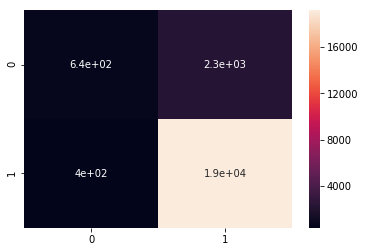

In [20]:
confusion_matrix_plot(y_test,pred)

### Accuracy vs Maximum Depth Plot

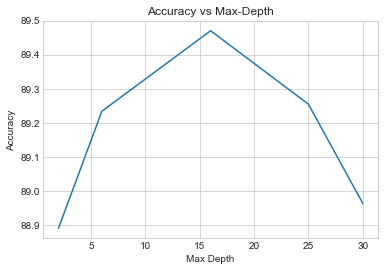

In [21]:
acc_vs_max_depth_plot(max_depth_list,a1.cv_results_['mean_test_f1_micro']*100)

In [22]:
from sklearn.tree import export_graphviz
export_graphviz(dt_optimal, out_file='dot_data_bow.dot',filled=True, rounded=True,special_characters=True,feature_names=count_vect.get_feature_names())


### Bigram - Decision Trees

### Best Hyperparameter Max-Depth using GridSearchCV

In [23]:
x_train, x_test, y_train, y_test = train_test_split(dt_data['Cleaned_Text'] ,dt_data['Score'], test_size=0.3, shuffle = False)
x_test.head()

347196    top favorit popcorn season time purchas area n...
87753     genuin high fructos corn syrup one buy heinz k...
74084     seem prefer nice juici meal fussi eater sweet ...
118859    love use pomona pectin allow use less sugar re...
37155     use season mixtur brown sugar chipotl chili po...
Name: Cleaned_Text, dtype: object

In [24]:
ngram_vect = CountVectorizer(ngram_range=(1,2))
x_train = ngram_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = ngram_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [25]:
dtc = DecisionTreeClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 3)
max_depth_list = sorted(np.random.randint(1,40,5))
param_grid = {'max_depth':max_depth_list}
grid_search = GridSearchCV(dtc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1,scoring = {'f1_micro'},refit= 'f1_micro')
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [8, 18, 33, 34, 38]},
       pre_dispatch='2*n_jobs', refit='f1_micro',
       return_train_score='warn', scoring={'f1_micro'}, verbose=1)

In [26]:
save_data(grid_search,'bigram_grid_search_dt')

In [27]:
a1 = load_data('bigram_grid_search_dt')

In [28]:
print('Best Max-Depth ',a1.best_params_['max_depth'])
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best Max-Depth  8
Best Accuracy 89.544127%


In [29]:
from sklearn.metrics import accuracy_score
dt_optimal = DecisionTreeClassifier(max_depth = a1.best_params_['max_depth'])
dt_optimal.fit(x_train, y_train)
pred = dt_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [30]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.293333,0.89227,0.984264,0.936012


True Positive 19265
True Negative 601
False Positive 2326
False Negative 308


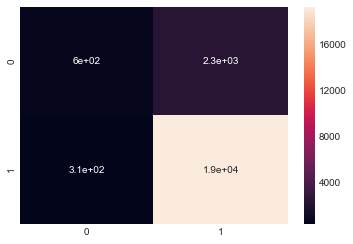

In [31]:
confusion_matrix_plot(y_test,pred)

### Accuracy vs Maximum Depth Plot

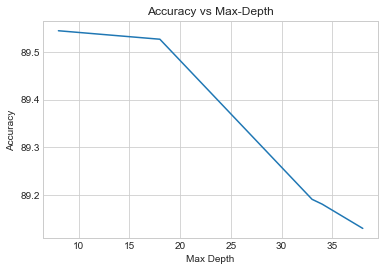

In [32]:
acc_vs_max_depth_plot(max_depth_list,a1.cv_results_['mean_test_f1_micro']*100)

In [34]:
from sklearn.tree import export_graphviz
export_graphviz(dt_optimal, out_file='dot_data_bigram.dot',filled=True, rounded=True,special_characters=True,feature_names=ngram_vect.get_feature_names())

### Tf-Idf Decision Trees

### Best Hyperparameter Max-Depth using GridSearchCV

In [35]:
x_train, x_test, y_train, y_test = train_test_split(dt_data['Cleaned_Text'] ,dt_data['Score'], test_size=0.3, shuffle = False)
x_test.head()

347196    top favorit popcorn season time purchas area n...
87753     genuin high fructos corn syrup one buy heinz k...
74084     seem prefer nice juici meal fussi eater sweet ...
118859    love use pomona pectin allow use less sugar re...
37155     use season mixtur brown sugar chipotl chili po...
Name: Cleaned_Text, dtype: object

In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = tf_idf_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [37]:
dtc = DecisionTreeClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 3)
max_depth_list = sorted(np.random.randint(1,40,5))
param_grid = {'max_depth':max_depth_list}
grid_search = GridSearchCV(dtc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1,scoring = {'f1_micro'},refit= 'f1_micro')
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.1min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [11, 12, 14, 26, 34]},
       pre_dispatch='2*n_jobs', refit='f1_micro',
       return_train_score='warn', scoring={'f1_micro'}, verbose=1)

In [38]:
save_data(grid_search,'tfidf_grid_search_dt')

In [39]:
a1 = load_data('tfidf_grid_search_dt')

In [40]:
print('Best Max-Depth ',a1.best_params_['max_depth'])
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best Max-Depth  14
Best Accuracy 89.663492%


In [41]:
from sklearn.metrics import accuracy_score
dt_optimal = DecisionTreeClassifier(max_depth = a1.best_params_['max_depth'])
dt_optimal.fit(x_train, y_train)
pred = dt_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [42]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.497778,0.89557,0.982323,0.936943


True Positive 19227
True Negative 685
False Positive 2242
False Negative 346


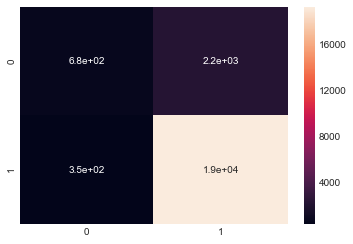

In [43]:
confusion_matrix_plot(y_test,pred)

### Accuracy vs Maximum Depth Plot

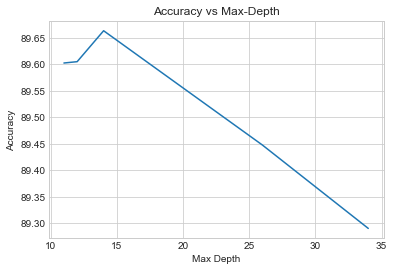

In [44]:
acc_vs_max_depth_plot(max_depth_list,a1.cv_results_['mean_test_f1_micro']*100)

In [45]:
from sklearn.tree import export_graphviz
export_graphviz(dt_optimal, out_file='dot_data_tfidf.dot',filled=True, rounded=True,special_characters=True,feature_names=tf_idf_vect.get_feature_names())

### Word2Vec - Decision Trees

### Best Hyperparameter Max-Depth using GridSearchCV

In [46]:
x_train, x_test, y_train, y_test = train_test_split(dt_data['Cleaned_Text'] ,dt_data['Score'], test_size=0.3, shuffle = False)

In [47]:
list_of_train_sent = []
for sent in x_train.values:
    list_of_train_sent.append(sent.split())

In [48]:
w2v_model = Word2Vec(list_of_train_sent,min_count=5,workers=4,size=100)
w2v_words = list(w2v_model.wv.vocab)

In [49]:
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_train_sent): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|██████████| 52500/52500 [01:04<00:00, 819.48it/s] 


In [50]:
sent_vectors_arr = np.asarray(sent_vectors)
x_train = normalize(sent_vectors_arr)

In [51]:
list_of_test_sent = []
for sent in x_test.values:
    list_of_test_sent.append(sent.split())

In [52]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_test_sent): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|██████████| 22500/22500 [00:31<00:00, 717.31it/s]


In [53]:
sent_vectors_arr = np.asarray(sent_vectors)
x_test = normalize(sent_vectors_arr)

In [61]:
dtc = DecisionTreeClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 5)
max_depth_list = sorted(np.random.randint(1,100,10))
param_grid = {'max_depth':max_depth_list}
grid_search = GridSearchCV(dtc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1,scoring = {'f1_micro'},refit= 'f1_micro')
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [6, 24, 30, 35, 37, 58, 59, 78, 86, 89]},
       pre_dispatch='2*n_jobs', refit='f1_micro',
       return_train_score='warn', scoring={'f1_micro'}, verbose=1)

In [62]:
save_data(grid_search,'w2v_grid_search_dt')

In [63]:
a1 = load_data('w2v_grid_search_dt')

In [64]:
print('Best Max-Depth ',a1.best_params_['max_depth'])
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best Max-Depth  6
Best Accuracy 88.722286%


In [65]:
from sklearn.metrics import accuracy_score
dt_optimal = DecisionTreeClassifier(max_depth = a1.best_params_['max_depth'])
dt_optimal.fit(x_train, y_train)
pred = dt_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [66]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,87.804444,0.890845,0.97987,0.933239


True Positive 19179
True Negative 577
False Positive 2350
False Negative 394


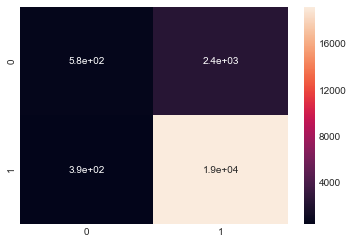

In [67]:
confusion_matrix_plot(y_test,pred)

### Accuracy vs Maximum Depth Plot

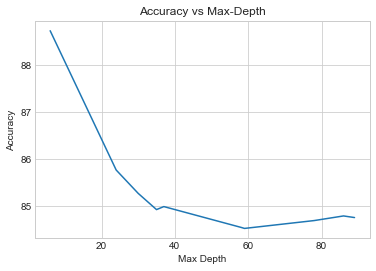

In [68]:
acc_vs_max_depth_plot(max_depth_list,a1.cv_results_['mean_test_f1_micro']*100)

### Tf-Idf Word2Vec Decision Trees

### Best Hyperparameter Max-Depth using GridSearchCV

In [69]:
x_train, x_test, y_train, y_test = train_test_split(dt_data['Cleaned_Text'],dt_data['Score'], test_size=0.3, random_state=0)

In [70]:
tf_idf_vect = TfidfVectorizer()
x_train = tf_idf_vect.fit_transform(x_train)

In [71]:
dict_dt = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [72]:
from tqdm import tqdm_notebook as tqdm

In [74]:
tfidf_feat= tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row=0;
for sent in tqdm(list_of_train_sent): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) and (word in tfidf_feat)):
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            #tf_idf = x_train[row, tfidf_feat.index(word)]
            tf_idf = dict_dt[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    row += 1

In [ ]:
tfidf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)
x_train = normalize(tfidf_sent_vectors_arr)
x_test = tf_idf_vect.transform(x_test)

In [ ]:
save_data(x_train,'tfidf_w2v_train_set_dt')

In [75]:
x_train = load_data('tfidf_w2v_train_set_dt')

In [ ]:
tfidf_feat= tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row=0;
for sent in tqdm(list_of_test_sent): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) and (word in tfidf_feat)):
            vec = w2v_model.wv[word]
            tf_idf = dict_svm[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    row += 1

In [ ]:
tfidf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)
x_test = normalize(tfidf_sent_vectors_arr)

In [ ]:
save_data(x_test,'tfidf_w2v_test_set_dt')

In [76]:
x_test = load_data('tfidf_w2v_test_set_dt')

In [77]:
dtc = DecisionTreeClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 5)
max_depth_list = sorted(np.random.randint(1,100,10))
param_grid = {'max_depth':max_depth_list}
grid_search = GridSearchCV(dtc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1,scoring = {'f1_micro'},refit= 'f1_micro')
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [8, 20, 23, 47, 51, 57, 58, 77, 95, 96]},
       pre_dispatch='2*n_jobs', refit='f1_micro',
       return_train_score='warn', scoring={'f1_micro'}, verbose=1)

In [78]:
save_data(grid_search,'tfidf_w2v_grid_search_dt')

In [79]:
a1 = load_data('tfidf_w2v_grid_search_dt')

In [80]:
print('Best Max-Depth ',a1.best_params_['max_depth'])
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best Max-Depth  8
Best Accuracy 87.995429%


In [81]:
from sklearn.metrics import accuracy_score
dt_optimal = DecisionTreeClassifier(max_depth = a1.best_params_['max_depth'])
dt_optimal.fit(x_train, y_train)
pred = dt_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [82]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.226667,0.882497,0.999698,0.937448


True Positive 19850
True Negative 1
False Positive 2643
False Negative 6


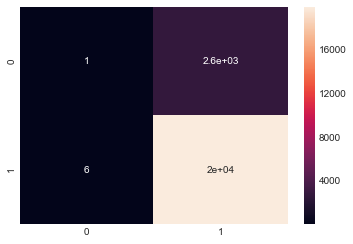

In [83]:
confusion_matrix_plot(y_test,pred)

### Accuracy vs Maximum Depth Plot

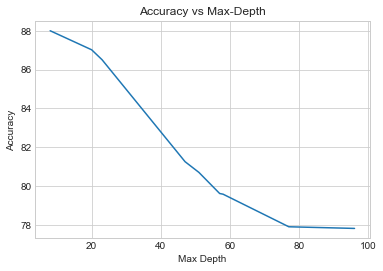

In [84]:
acc_vs_max_depth_plot(max_depth_list,a1.cv_results_['mean_test_f1_micro']*100)

### Summary

| Model | CV - Type | Best Max-Depth | Best Accuracy |
| --- | --- | --- | ---|
|     BOW      | Grid Search |       16       | 89.46971428571429 |
|    Bigram    | Grid Search |       8        | 89.54412698412698 |
|    Tf-Idf    | Grid Search |       14       | 89.66349206349207 |
|     W2V      | Grid Search |       6        |  88.7222857142857 |
| Tf-Idf - W2v | Grid Search |       8        | 87.99542857142856 |

### Procedure to solve the assignment

1. Preprocessing of text and time based splitting of train and test data. I have performed it already and have loaded it from a file.
2. Vectorizing the train data and applying the same vectorizer to test data to transform it into vectors.
3. Finding out the optimal maximum depth of the tree using Grid Search CV.
4. Finding out the performance of the model on test data using the Optimal Max. Depth that is obtained.
5. Evaluating the various performance metric values of the model that is obtained.
6. Plot the Confusion matrix using Seaborn.
7. Plot the Accuracy vs Maximum Depth plot to find out the Optimal Max. Depth.
8. Visualize the Decision Trees for various models using Graphviz.
9. Repeat steps 2 to 8 for vectorizers BOW,Bigram, Tf-Idf, Avg. Word2Vec, Tf-Idf Word2Vec